# San Francisco Rental Prices Dashboard

In this notebook, you will compile the visualizations from the previous analysis into functions that can be used for a Panel dashboard.

In [17]:
# imports
import panel as pn
pn.extension('plotly')
import plotly.express as px
import pandas as pd
import hvplot.pandas
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
import os
from pathlib import Path
from dotenv import load_dotenv

In [18]:
# Read the Mapbox API key
load_dotenv()
map_box_api = os.getenv("mapbox")
px.set_mapbox_access_token(map_box_api)

# Import Data

In [19]:
# Import the necessary CSVs to Pandas DataFrames
file_path = Path("Data/sfo_neighborhoods_census_data.csv")
sfo_data = pd.read_csv(file_path, index_col="year")
neighbor = pd.read_csv('Data/neighborhoods_coordinates.csv')

- - -

## Panel Visualizations

In this section, you will copy the code for each plot type from your analysis notebook and place it into separate functions that Panel can use to create panes for the dashboard. 

These functions will convert the plot object to a Panel pane.

Be sure to include any DataFrame transformation/manipulation code required along with the plotting code.

Return a Panel pane object from each function that can be used to build the dashboard.

Note: Remove any `.show()` lines from the code. We want to return the plots instead of showing them. The Panel dashboard will then display the plots.

In [20]:
# Define Panel Visualization Functions
def housing_units_per_year():
    """Housing Units Per Year."""
    units_per_year = sfo_data.groupby(sfo_data.index)['housing_units'].mean()
    ax = units_per_year.plot(kind='bar', 
                        ylim=(units_per_year.min() - units_per_year.std(), units_per_year.max() + units_per_year.std()), 
                        title='Housing Units in San Francisco from 2010 to 2016')
    plt.xlabel('Year')
    plt.ylabel('Housing Units')
    plt.close()
    return ax.figure
    
def average_gross_rent():
    """Average Gross Rent in San Francisco Per Year."""
    price_rent_per_year = sfo_data.groupby('year')[['sale_price_sqr_foot', 'gross_rent']].mean()
    ax = price_rent_per_year['gross_rent'].plot(title='Average Gross Rent by Year', color='red')
    plt.xlabel('Year')
    plt.ylabel('Price per SqFt')
    plt.close()
    return ax.figure
    

def average_sales_price():
    """Average Sales Price Per Year."""
    price_rent_per_year = sfo_data.groupby('year')[['sale_price_sqr_foot', 'gross_rent']].mean()
    ax = price_rent_per_year['sale_price_sqr_foot'].plot(title='Average Price per SqFt by Year', color='purple')
    plt.xlabel('Year')
    plt.ylabel('Gross Rent')
    plt.close()
    return ax.figure


def average_price_by_neighborhood():
    """Average Prices by Neighborhood."""
    grouped_by_year_nbr = sfo_data.groupby(['year', 'neighborhood']).mean().reset_index()
    return grouped_by_year_nbr[['sale_price_sqr_foot', 'neighborhood']].hvplot.line(xlabel='Year', ylabel='Avg. Sale Price per SqFt', groupby='neighborhood')


def top_most_expensive_neighborhoods():
    """Top 10 Most Expensive Neighborhoods."""
    top_10_nbr = sfo_data[['neighborhood', 'sale_price_sqr_foot', 'housing_units', 'gross_rent']].groupby('neighborhood').mean().nlargest(10, 'sale_price_sqr_foot')
    return top_10_nbr['sale_price_sqr_foot'].hvplot.bar(xlabel='Neighborhood', 
                                                        ylabel='Avg. Sale Price per SqFt', 
                                                        title='Top 10 Expensive Neighborhood in SFO', 
                                                        rot=90, 
                                                        height=400)
    


def most_expensive_neighborhoods_rent_sales():
    """Comparison of Rent and Sales Prices of Most Expensive Neighborhoods."""   
    grouped_by_year_nbr = sfo_data.groupby(['year', 'neighborhood']).mean().reset_index()
    top_10_nbr = sfo_data[['neighborhood', 'sale_price_sqr_foot', 'housing_units', 'gross_rent']].groupby('neighborhood').mean().nlargest(10, 'sale_price_sqr_foot')
    top_10_expensive_nbr_by_year = grouped_by_year_nbr.loc[grouped_by_year_nbr['neighborhood'].isin(top_10_nbr.index)]
    return top_10_expensive_nbr_by_year.hvplot.bar(x='year', 
                               y=['gross_rent', 'sale_price_sqr_foot'], 
                               groupby='neighborhood', 
                               title='Top 10 Neighborhoods Comparing Cost to Purchase VS Rental Income', 
                               xlabel='Year', 
                               ylabel=' US Dollar', 
                               rot=90, 
                               height=400)

    
    
def parallel_coordinates():
    """Parallel Coordinates Plot."""
    grouped_by_year_nbr = sfo_data.groupby(['year', 'neighborhood']).mean().reset_index()
    top_10_nbr = sfo_data[['neighborhood', 'sale_price_sqr_foot', 'housing_units', 'gross_rent']].groupby('neighborhood').mean().nlargest(10, 'sale_price_sqr_foot')
    expensive_nbr_per_year = grouped_by_year_nbr[grouped_by_year_nbr["neighborhood"].isin(top_10_nbr.index)]
    top_10_expensive_nbr_avg = expensive_nbr_per_year.groupby(['neighborhood']).mean().sort_values('sale_price_sqr_foot', ascending=False).reset_index()
    top_10_expensive_nbr_avg.drop(columns='year', inplace=True)
    return px.parallel_coordinates(top_10_expensive_nbr_avg, 
                        dimensions=['sale_price_sqr_foot', 'housing_units', 'gross_rent'], 
                        color='sale_price_sqr_foot', 
                        title = 'Cost Analysis of Most Expensive Neighborhood in San Francisco',
                        height=400)



def parallel_categories():
    """Parallel Categories Plot."""
    grouped_by_year_nbr = sfo_data.groupby(['year', 'neighborhood']).mean().reset_index()
    top_10_nbr = sfo_data[['neighborhood', 'sale_price_sqr_foot', 'housing_units', 'gross_rent']].groupby('neighborhood').mean().nlargest(10, 'sale_price_sqr_foot')
    expensive_nbr_per_year = grouped_by_year_nbr[grouped_by_year_nbr["neighborhood"].isin(top_10_nbr.index)]
    top_10_expensive_nbr_avg = expensive_nbr_per_year.groupby(['neighborhood']).mean().sort_values('sale_price_sqr_foot', ascending=False).reset_index()
    top_10_expensive_nbr_avg.drop(columns='year', inplace=True)
    return px.parallel_categories(top_10_expensive_nbr_avg, 
                       dimensions=['neighborhood','sale_price_sqr_foot', 'housing_units', 'gross_rent'], 
                       color='sale_price_sqr_foot', 
                       title = 'Cost Analysis of Most Expensive Neighborhood in San Francisco',
                       height=400)



def neighborhood_map():
    """Neighborhood Map."""
    mean_by_nbr = sfo_data.groupby('neighborhood').mean().reset_index()
    joined = pd.merge(mean_by_nbr, neighbor, left_on='neighborhood', right_on='Neighborhood', how='inner')
    joined.drop(columns='Neighborhood', inplace=True)
    px.set_mapbox_access_token(map_box_api)
    return px.scatter_mapbox(joined, 
                            lat='Lat', 
                            lon='Lon', 
                            color='gross_rent', 
                            size='sale_price_sqr_foot', 
                            title='Comparing Cost to Purchase VS Rental Income on Map',
                            height=500,
                            width=1000,
                            zoom=11)

def sunburst():
    """Sunburst Plot."""
    grouped_by_year_nbr = sfo_data.groupby(['year', 'neighborhood']).mean().reset_index()
    top_10_nbr = sfo_data[['neighborhood', 'sale_price_sqr_foot', 'housing_units', 'gross_rent']].groupby('neighborhood').mean().nlargest(10, 'sale_price_sqr_foot')
    expensive_nbr_per_year = grouped_by_year_nbr[grouped_by_year_nbr["neighborhood"].isin(top_10_nbr.index)]
    return px.sunburst(expensive_nbr_per_year, 
            path=['year', 'neighborhood'], 
            values='sale_price_sqr_foot', 
            color='gross_rent', 
            color_continuous_scale='Blues', 
            title='Cost Analysis of Most Expensive Neighborhood in San Francisco per Year',
            height=600)


## Panel Dashboard

In this section, you will combine all of the plots into a single dashboard view using Panel. Be creative with your dashboard design!

Traceback (most recent call last):
 File "C:\Users\sator\anaconda3\envs\pyvizenv\lib\site-packages\pyviz_comms\__init__.py", line 325, in _handle_msg
 self._on_msg(msg)
 File "C:\Users\sator\anaconda3\envs\pyvizenv\lib\site-packages\panel\viewable.py", line 273, in _on_msg
 doc.unhold()
 File "C:\Users\sator\anaconda3\envs\pyvizenv\lib\site-packages\bokeh\document\document.py", line 669, in unhold
 self._trigger_on_change(event)
 File "C:\Users\sator\anaconda3\envs\pyvizenv\lib\site-packages\bokeh\document\document.py", line 1180, in _trigger_on_change
 self._with_self_as_curdoc(event.callback_invoker)
 File "C:\Users\sator\anaconda3\envs\pyvizenv\lib\site-packages\bokeh\document\document.py", line 1198, in _with_self_as_curdoc
 return f()
 File "C:\Users\sator\anaconda3\envs\pyvizenv\lib\site-packages\bokeh\util\callback_manager.py", line 161, in invoke
 callback(attr, old, new)
 File "C:\Users\sator\anaconda3\envs\pyvizenv\lib\site-packages\panel\reactive.py", line 301, in _comm_change
 self._process_events({attr: new})
 File "C:\Users\sator\anaconda3\envs\pyvizenv\lib\site-packages\panel\reactive.py", line 262, in _process_events
 self.param.set_param(**self_events)
 File "C:\Users\sator\anaconda3\envs\pyvizenv\lib\site-packages\param\parameterized.py", line 1526, in set_param
 self_._batch_call_watchers()
 File "C:\Users\sator\anaconda3\envs\pyvizenv\lib\site-packages\param\parameterized.py", line 1665, in _batch_call_watchers
 self_._execute_watcher(watcher, events)
 File "C:\Users\sator\anaconda3\envs\pyvizenv\lib\site-packages\param\parameterized.py", line 1627, in _execute_watcher
 watcher.fn(*args, **kwargs)
 File "C:\Users\sator\anaconda3\envs\pyvizenv\lib\site-packages\param\parameterized.py", line 520, in caller
 return function()
 File "C:\Users\sator\anaconda3\envs\pyvizenv\lib\site-packages\param\parameterized.py", line 351, in _depends
 return func(*args,**kw)
 File "C:\Users\sator\anaconda3\envs\pyvizenv\lib\site-packages\panel\pane\plotly.py", line 153, in _update_figure_layout
 self._figure.plotly_relayout(self.relayout_data)
 File "C:\Users\sator\anaconda3\envs\pyvizenv\lib\site-packages\plotly\basedatatypes.py", line 2601, in plotly_relayout
 relayout_changes = self._perform_plotly_relayout(relayout_data)
 File "C:\Users\sator\anaconda3\envs\pyvizenv\lib\site-packages\plotly\basedatatypes.py", line 2641, in _perform_plotly_relayout
 key_path_str=key_path_str
ValueError: 
Invalid property path 'mapbox._derived' for layout

Column
    [0] Markdown(str)
    [1] Markdown(str)
    [2] Tabs
        [0] Column
            [0] Plotly(Figure)
        [1] Row
            [0] Matplotlib(Figure)
            [1] Matplotlib(Figure)
            [2] Matplotlib(Figure)
        [2] Column
            [0] Row
                [0] HoloViews(DynamicMap)
                [1] Column
                    [0] WidgetBox
                        [0] Select(margin=(20, 20, 20, 20), name='neighborhood', options=['Alamo Square', ...], value='Alamo Square', width=250)
                    [1] VSpacer()
            [1] HoloViews(Bars)
            [2] Row
                [0] HoloViews(DynamicMap)
                [1] Column
                    [0] WidgetBox
                        [0] Select(margin=(20, 20, 20, 20), name='neighborhood', options=['Cow Hollow', ...], value='Cow Hollow', width=250)
                    [1] VSpacer()
        [3] Column
            [0] Plotly(Figure, visible=False)
            [1] Plotly(Figure, visible=False)
        [4] Column
            [0] Plotly(Figure, visible=False)
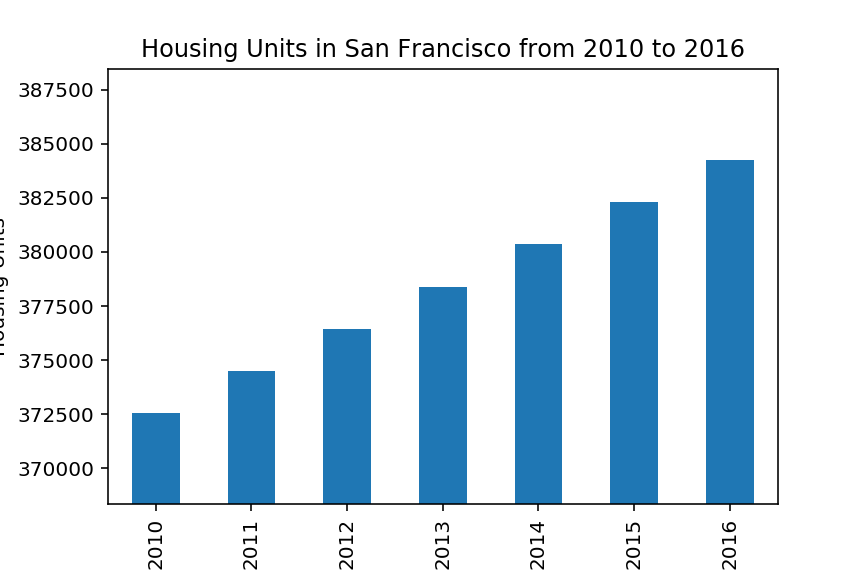
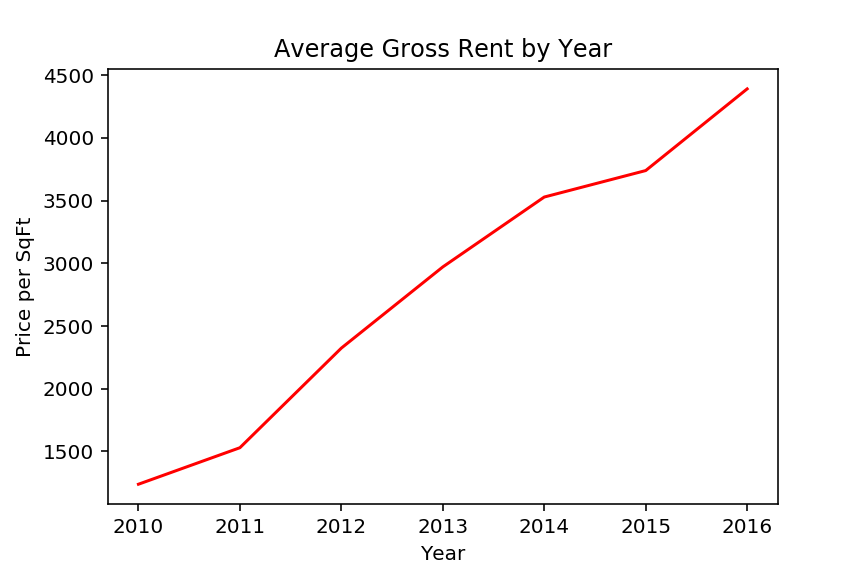
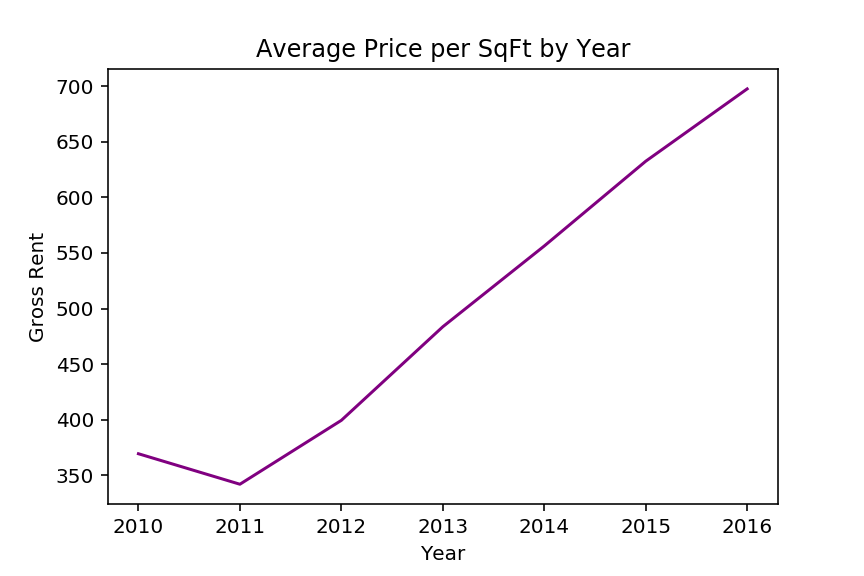

In [21]:
# Create a Title for the Dashboard
map_overview_col = pn.Column(neighborhood_map())
yearly_analysis_row = pn.Row(housing_units_per_year(), average_gross_rent(), average_sales_price())
neighborhood_analysis_col = pn.Column(average_price_by_neighborhood(), top_most_expensive_neighborhoods(), most_expensive_neighborhoods_rent_sales())
prallel_analysis_col = pn.Column(parallel_coordinates(), parallel_categories())
sunburst_analysis_col = pn.Column(sunburst())

# Create a tab layout for the dashboard
tabs = pn.Tabs(('Overview', map_overview_col),
               ('Yeaerly Market Analysis', yearly_analysis_row),
               ('Neighborhood Analysis', neighborhood_analysis_col),
               ('Prallel Plot Analysis', prallel_analysis_col),
               ('Sunburst Analysis', sunburst_analysis_col))

dashboard_home = pn.Column("# Real Estate Analysis of San Francisco from 2010 to 2016", 
                     """The dashboard presents an analysis of San Francisco's real estate market. We look at the histarical data of number of units,
                     sale price per square feet and gross rent for each neighborhood between 2010 and 2016.
                     """,
                     tabs)
# Create the dashboard
# YOUR CODE HERE!
dashboard_home

## Serve the Panel Dashboard

Column
    [0] Markdown(str)
    [1] Markdown(str)
    [2] Tabs
        [0] Column
            [0] Plotly(Figure)
        [1] Row
            [0] Matplotlib(Figure)
            [1] Matplotlib(Figure)
            [2] Matplotlib(Figure)
        [2] Column
            [0] Row
                [0] HoloViews(DynamicMap)
                [1] Column
                    [0] WidgetBox
                        [0] Select(margin=(20, 20, 20, 20), name='neighborhood', options=['Alamo Square', ...], value='Alamo Square', width=250)
                    [1] VSpacer()
            [1] HoloViews(Bars)
            [2] Row
                [0] HoloViews(DynamicMap)
                [1] Column
                    [0] WidgetBox
                        [0] Select(margin=(20, 20, 20, 20), name='neighborhood', options=['Cow Hollow', ...], value='Cow Hollow', width=250)
                    [1] VSpacer()
        [3] Column
            [0] Plotly(Figure, visible=False)
            [1] Plotly(Figure, visible=False)
        [4] Column
            [0] Plotly(Figure, visible=False)
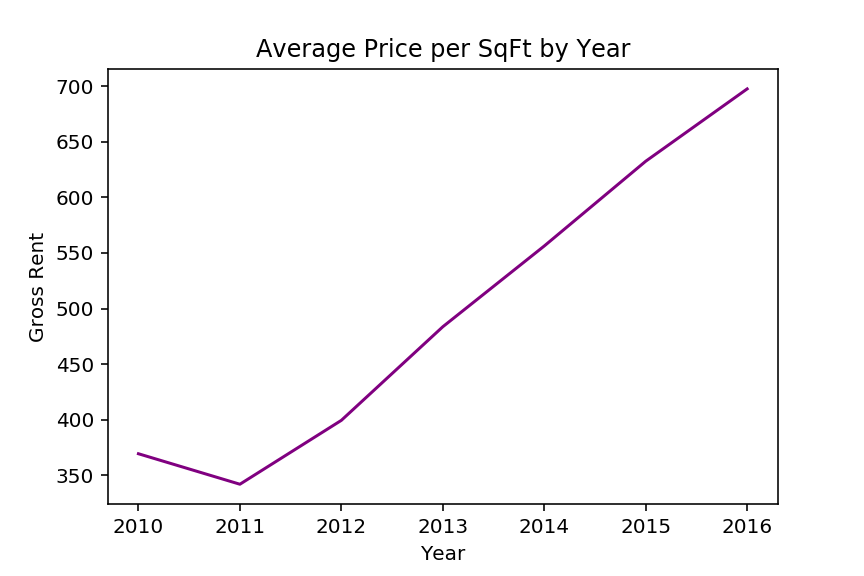
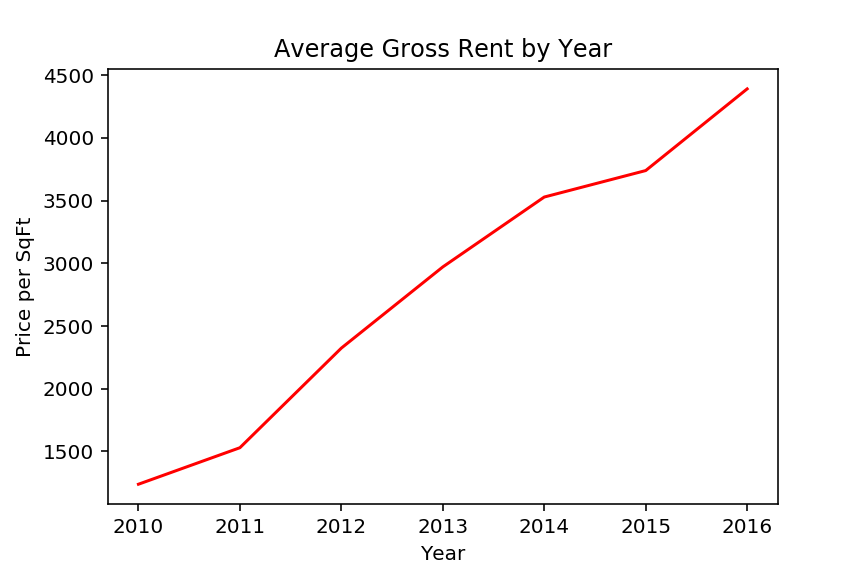
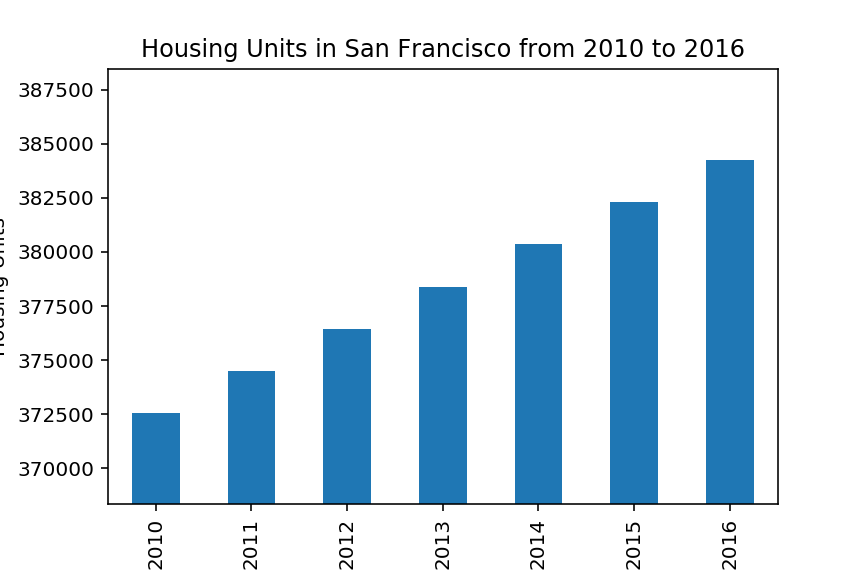

In [22]:
# Serve the# dashboardd
dashboard_home.servable()

# Debugging

Note: Some of the Plotly express plots may not render in the notebook through the panel functions.

However, you can test each plot by uncommenting the following code

In [23]:
#housing_units_per_year()

In [24]:
#average_gross_rent()

In [25]:
#average_sales_price()

In [26]:
#average_price_by_neighborhood()

In [27]:
#top_most_expensive_neighborhoods()

In [28]:
#most_expensive_neighborhoods_rent_sales()

In [29]:
#neighborhood_map().show()

In [30]:
#parallel_categories()

In [31]:
#parallel_coordinates()

In [32]:
#sunburst()